In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from transformers import RobertaTokenizer, RobertaModel
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import DataLoader, Subset
from scipy.stats import pearsonr
from tqdm import tqdm
from sklearn.exceptions import FitFailedWarning
import warnings
from sklearn.model_selection import ParameterSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib
from sklearn.base import clone


In [2]:
import torch

# 检查是否有可用的 GPU
if torch.cuda.is_available():
    print("CUDA 可用，GPU 可用。")
    print(f"CUDA 版本: {torch.version.cuda}")
    print(f"GPU 数量: {torch.cuda.device_count()}")
    print(f"当前设备名称: {torch.cuda.get_device_name(0)}")
    print(f"当前设备总内存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("CUDA 不可用，仅支持 CPU。")


CUDA 不可用，仅支持 CPU。


In [2]:
data=pd.read_excel("./fish_unique.xlsx")
data=data.dropna()
smiles_data = data['SMILES_Canonical_RDKit'].tolist()
mgperL = data['mgperL'].values
Duration_Value= data['Duration_Value'].values

In [3]:
data

Duration_Value effect endpoint species_group          CAS  \
0                 0.0    DVP     EC10          fish  100646-51-3   
1                 0.0    DVP     EC10          fish    1571-75-1   
2                 0.0    DVP     EC10          fish    1619-34-7   
3                 0.0    DVP     EC10          fish  163702-05-4   
4                 0.0    DVP     EC10          fish  163702-08-7   
...               ...    ...      ...           ...          ...   
26904         25920.0    REP     EC10          fish     557-09-5   
26905         25920.0    REP     EC10          fish     557-28-8   
26906         25920.0    REP     EC10          fish   68092-46-6   
26907         25920.0    REP     EC10          fish    7733-02-0   
26908         25920.0    REP     EC10          fish   84682-03-1   

                                 SMILES_Canonical_RDKit     mgperL  
0            CCOC(=O)C(C)Oc1ccc(Oc2cnc3cc(Cl)ccc3n2)cc1   0.190000  
1                  CC(c1ccccc1)(c1ccc(O)cc1)c1ccc(O)cc1   0.455000  
2                                         OC1CN2CCC1CC2  12.718630  
3                      CCOC(F)(F)C(F)(F)C(F)(F)C(F)(F)F   1.320453  
4                       COC(F)(F)C(F)(C(F)(F)F)C(F)(F)F   1.250319  
...                                                 ...        ...  
26904          CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2]   0.530000  
26905                    CCC(=O)[O-].CCC(=O)[O-].[Zn+2]   0.530000  
26906  Cc1cccc(C(=O)[O-])c1.Cc1cccc(C(=O)[O-])c1.[Zn+2]   0.530000  
26907                          O=S(=O)([O-])[O-].[Zn+2]   0.530000  
26908                    CC(CC(=O)[O-])CC(C)(C)C.[Zn+2]   0.530000  

[26909 rows x 7 columns]

In [4]:
# 数据增强函数：简单的 SMILES 序列翻转
def augment_smiles(smiles):
    """简单的数据增强方法，例如旋转 SMILES 字符串"""
    if random.random() > 0.5:
        return smiles[::-1]  # 翻转字符串
    return smiles

# 根据 mgperL 浓度生成分类标签
def generate_labels(mgperL):
    """根据 mgperL 的浓度范围生成分类标签"""
    if mgperL < 0.2:
        return 0  # high
    elif 0.2 <= mgperL < 1.5:
        return 1  # mid
    elif 1.5 <= mgperL < 3.5:
        return 2  # mid
    else:
        return 3  # low

# 数据集定义
class SMILES_Dataset(Dataset):
    def __init__(self, smiles, reg_labels, class_labels):
        self.smiles = smiles
        self.reg_labels = reg_labels  # 回归任务标签 (mgperL)
        self.class_labels = class_labels  # 分类任务标签

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        #smiles = augment_smiles(self.smiles[idx])  # 数据增强
        smiles = self.smiles[idx]  # 数据增强
        reg_label = self.reg_labels[idx]
        class_label = self.class_labels[idx]
        tokens = tokenizer(smiles, padding='max_length', truncation=True, max_length=128, return_tensors="pt")
        return tokens, torch.tensor(reg_label, dtype=torch.float32), torch.tensor(class_label, dtype=torch.long)

# 多任务模型定义
class ChemBERTa_MultiTask(nn.Module):
    def __init__(self, num_classes):
        super(ChemBERTa_MultiTask, self).__init__()
        # 加载预训练的ChemBERTa模型
        self.chemberta = chemberta_model
        hidden_size = self.chemberta.config.hidden_size  # 一般为768
        # 回归任务的全连接层
        self.regressor = nn.Sequential(
            nn.Linear(hidden_size, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

        # 分类任务的全连接层
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 4)
        )

    def forward(self, tokens):
        output = self.chemberta(**tokens)
        cls_embedding = output.last_hidden_state[:, 0, :]  # [CLS] token 嵌入
        reg_output = self.regressor(cls_embedding)  # 回归任务输出
        class_output = self.classifier(cls_embedding)  # 分类任务输出
        return reg_output, class_output

In [5]:
# 加载 ChemBERTa 模型和 tokenizer
model_name = "../models/chemBERTa"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
chemberta_model = RobertaModel.from_pretrained(model_name)

/root/miniconda3/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [6]:
# 初始化多任务模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ChemBERTa_MultiTask(chemberta_model).to(device)

In [7]:
# 加载最佳模型
model.load_state_dict(torch.load('./FISH_MT_MODEL.pth', map_location=torch.device('cpu')))


<All keys matched successfully>

In [8]:


# 提取 SMILES 的嵌入表示

# 提取 SMILES 的嵌入表示
def extract_embeddings(smiles_list, model, tokenizer, device):
    embeddings = []
    model.eval()  # 设置模型为评估模式
    with torch.no_grad():
        for smiles in smiles_list:
            # Tokenize the SMILES string
            tokens = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
            
            # 通过 ChemBERTa 模型获得输出
            outputs = model.chemberta(**tokens)  # 提取 ChemBERTa 模型的输出
            
            # 提取 [CLS] token 的嵌入作为 SMILES 的整体嵌入
            cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # 获取多维的 [CLS] 嵌入
            embeddings.append(cls_embedding)
    
    return np.vstack(embeddings)  # 将所有嵌入拼接成一个矩阵

# 提取嵌入
smiles_embeddings = extract_embeddings(smiles_data, model, tokenizer, device)

In [9]:
from matplotlib import font_manager
# 指定字体路径
font_path = '../front/timesbd.ttf'
prop = font_manager.FontProperties(fname=font_path)

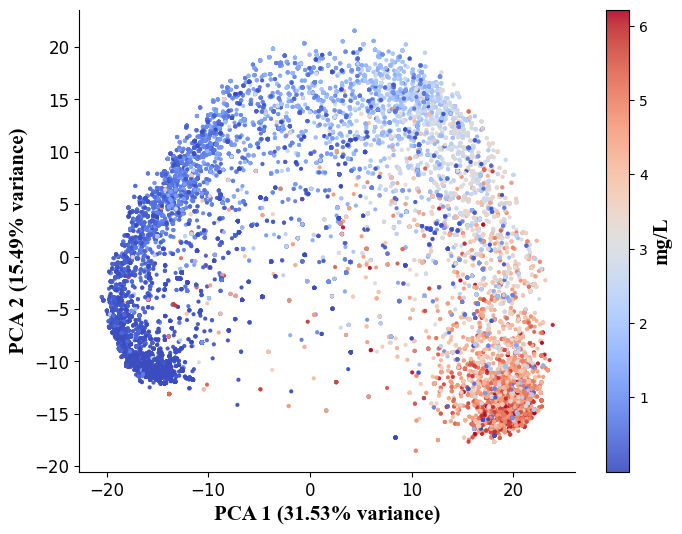

In [10]:
# 使用 PCA 对嵌入进行降维，同时获取主成分的解释方差百分比
def apply_pca(embeddings, n_components=2):
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(embeddings)
    explained_variance = pca.explained_variance_ratio_  # 获取每个主成分的解释方差
    return pca_result, explained_variance

# 可视化函数，同时显示解释方差百分比
def plot_pca_with_variance(pca_result, labels, explained_variance):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='coolwarm', alpha=0.9,s=4)
    # 添加 colorbar，不指定 fontsize 参数
    cbar = plt.colorbar(scatter)
    cbar.set_label('mg/L', fontsize=15,fontproperties=prop)  # 在此处设置字体大小
    plt.xlabel(f'PCA 1 ({explained_variance[0]*100:.2f}% variance)', fontsize=15,fontproperties=prop)
    plt.ylabel(f'PCA 2 ({explained_variance[1]*100:.2f}% variance)', fontsize=15,fontproperties=prop)

     # 获取当前坐标轴对象
    ax = plt.gca()

    # 设置所有边框的可见性，并确保框线颜色正常显示
    ax.spines['top'].set_visible(True)    # 显示顶部框线
    ax.spines['right'].set_visible(True)  # 显示右侧框线
    ax.spines['top'].set_color('black')   # 设置顶部框线颜色为黑色
    ax.spines['right'].set_color('black') # 设置右侧框线颜色为黑色
    ax.spines['top'].set_linewidth(1.5)   # 设置顶部框线的宽度
    ax.spines['right'].set_linewidth(1.5) # 设置右侧框线的宽度

    # 让其余边框可见（通常默认已可见）
    ax.spines['top'].set_visible(False)  # 显示左侧框线
    ax.spines['right'].set_visible(False)  # 显示底部框线
    
    ax.tick_params(axis='both', labelsize=12)  # 设置x轴和y轴刻度标签的字体大小为12

    
    plt.show()


mgperL=np.log1p(mgperL)
# 使用 PCA 降维，并获取解释方差
pca_result, explained_variance = apply_pca(smiles_embeddings, n_components=2)

# 绘制 PCA 图，并显示每个主成分的解释方差百分比
plot_pca_with_variance(pca_result, mgperL, explained_variance)

In [11]:
np.save('./fish_unique_smiles_embeddings.npy', smiles_embeddings)

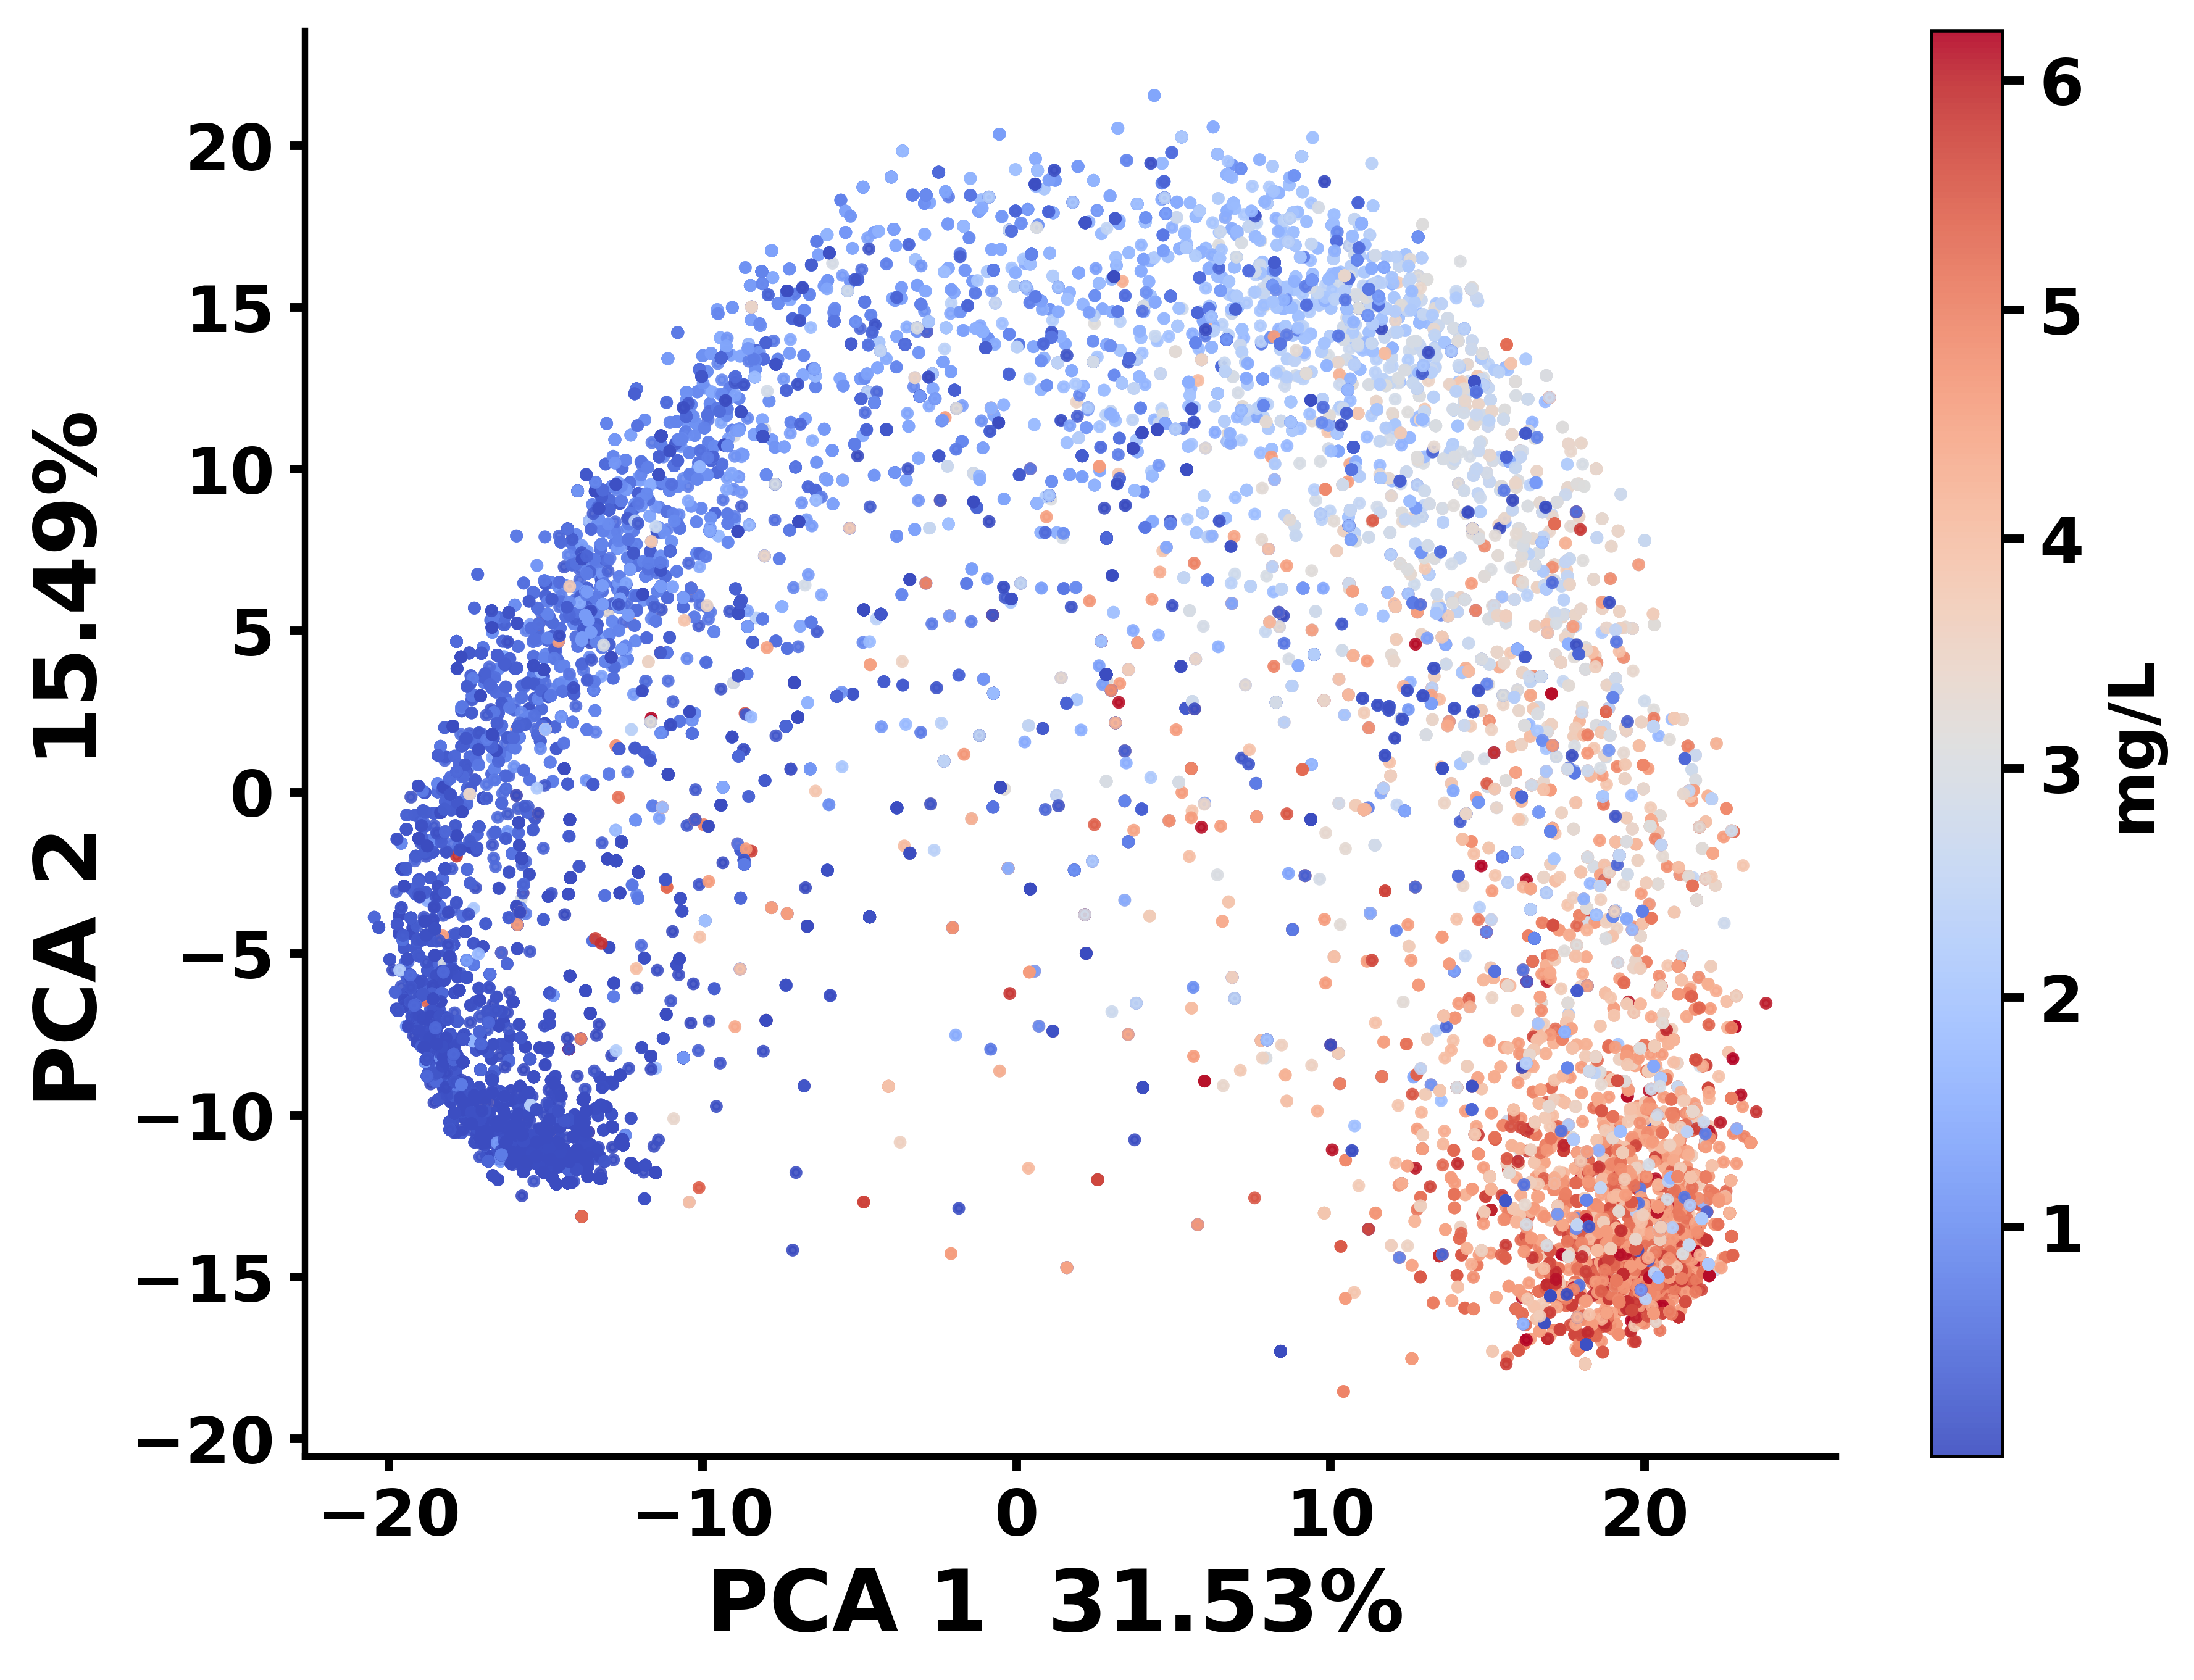

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


smiles_embeddings = np.load('./fish_unique_smiles_embeddings.npy')


data=pd.read_excel("./fish_unique.xlsx")
data=data.dropna()

mgperL = data['mgperL'].values
mgperL=np.log1p(mgperL)




# 使用 PCA 对嵌入进行降维，同时获取主成分的解释方差百分比
def apply_pca(embeddings, n_components=2):
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(embeddings)
    explained_variance = pca.explained_variance_ratio_  # 获取每个主成分的解释方差
    return pca_result, explained_variance


    
# 可视化函数，同时显示解释方差百分比，并加粗字体
def plot_pca_with_variance(pca_result, labels, explained_variance):
    plt.figure(figsize=(8, 6), dpi=500)
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='coolwarm', alpha=0.9,s=4)
    # 添加 colorbar，不指定 fontsize 参数
    cbar = plt.colorbar(scatter)
    cbar.set_label('mg/L', fontsize=15,fontweight='bold')  # 在此处设置字体大小
    #cbar = ax.collections[0].colorbar
    cbar.ax.yaxis.set_tick_params(labelsize=15, width=2, length=5)
    for label in cbar.ax.get_yticklabels():
        label.set_fontweight('bold')  # 让刻度标签加粗
    
    plt.xlabel(f'PCA 1  {explained_variance[0]*100:.2f}% ', fontsize=20, fontweight='bold')
    plt.ylabel(f'PCA 2  {explained_variance[1]*100:.2f}% ', fontsize=20, fontweight='bold')

     # 获取当前坐标轴对象
    ax = plt.gca()

    ax.spines['top'].set_visible(False)  # 隐藏左侧框线
    ax.spines['right'].set_visible(False)  # 隐藏底部框线
    ax.spines['top'].set_color('black')   
    ax.spines['right'].set_color('black') 
    ax.spines['top'].set_linewidth(1.5)   
    ax.spines['right'].set_linewidth(1.5) 

    # 让其余边框可见（通常默认已可见）
    ax.spines['bottom'].set_visible(True)  
    ax.spines['left'].set_visible(True)  
    ax.spines['bottom'].set_color('black')  
    ax.spines['left'].set_color('black')  
    ax.spines['bottom'].set_linewidth(1.5)  
    ax.spines['left'].set_linewidth(1.5)  
    

    # 加粗 x 轴和 y 轴的刻度
    ax.tick_params(axis='both', labelsize=15, width=2)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')  # 加粗刻度标签
    
    plt.show()
    



# 使用 PCA 降维，并获取解释方差
pca_result, explained_variance = apply_pca(smiles_embeddings, n_components=2)

# 绘制 PCA 图，并显示每个主成分的解释方差百分比
plot_pca_with_variance(pca_result, mgperL, explained_variance)

In [ ]:
#val_r2 = r2_score(np.expm1(all_labels), np.expm1(all_preds))  # 还原 log1p 的值

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA



smiles_embeddings = np.load('./fish_unique_smiles_embeddings.npy')


data=pd.read_excel("./fish_unique.xlsx")
data=data.dropna()

mgperL = data['mgperL'].values
mgperL=np.log1p(mgperL)



# 根据 mgperL 浓度生成分类标签
def generate_labels(mgperL):
    """根据 mgperL 的浓度范围生成分类标签"""
    if mgperL < 0.2:
        return 0  # high
    elif 0.2 <= mgperL < 1.5:
        return 1  # mid
    elif 1.5 <= mgperL < 3.5:
        return 2  # mid
    else:
        return 3  # low
# 生成分类标签    
classification_labels = [generate_labels(mg) for mg in mgperL]


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import davies_bouldin_score
import pandas as pd

# 假设 smiles_embeddings 是 [N, 768] 的词嵌入，classification_labels 是 [N] 的分类标签 (如 0,1,2,3)

# 使用 t-SNE 降维
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_result = tsne.fit_transform(smiles_embeddings)

# 直接使用离散标签作为分组
dbi_tsne = davies_bouldin_score(tsne_result, classification_labels)



/root/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [ ]:
dbi_tsne

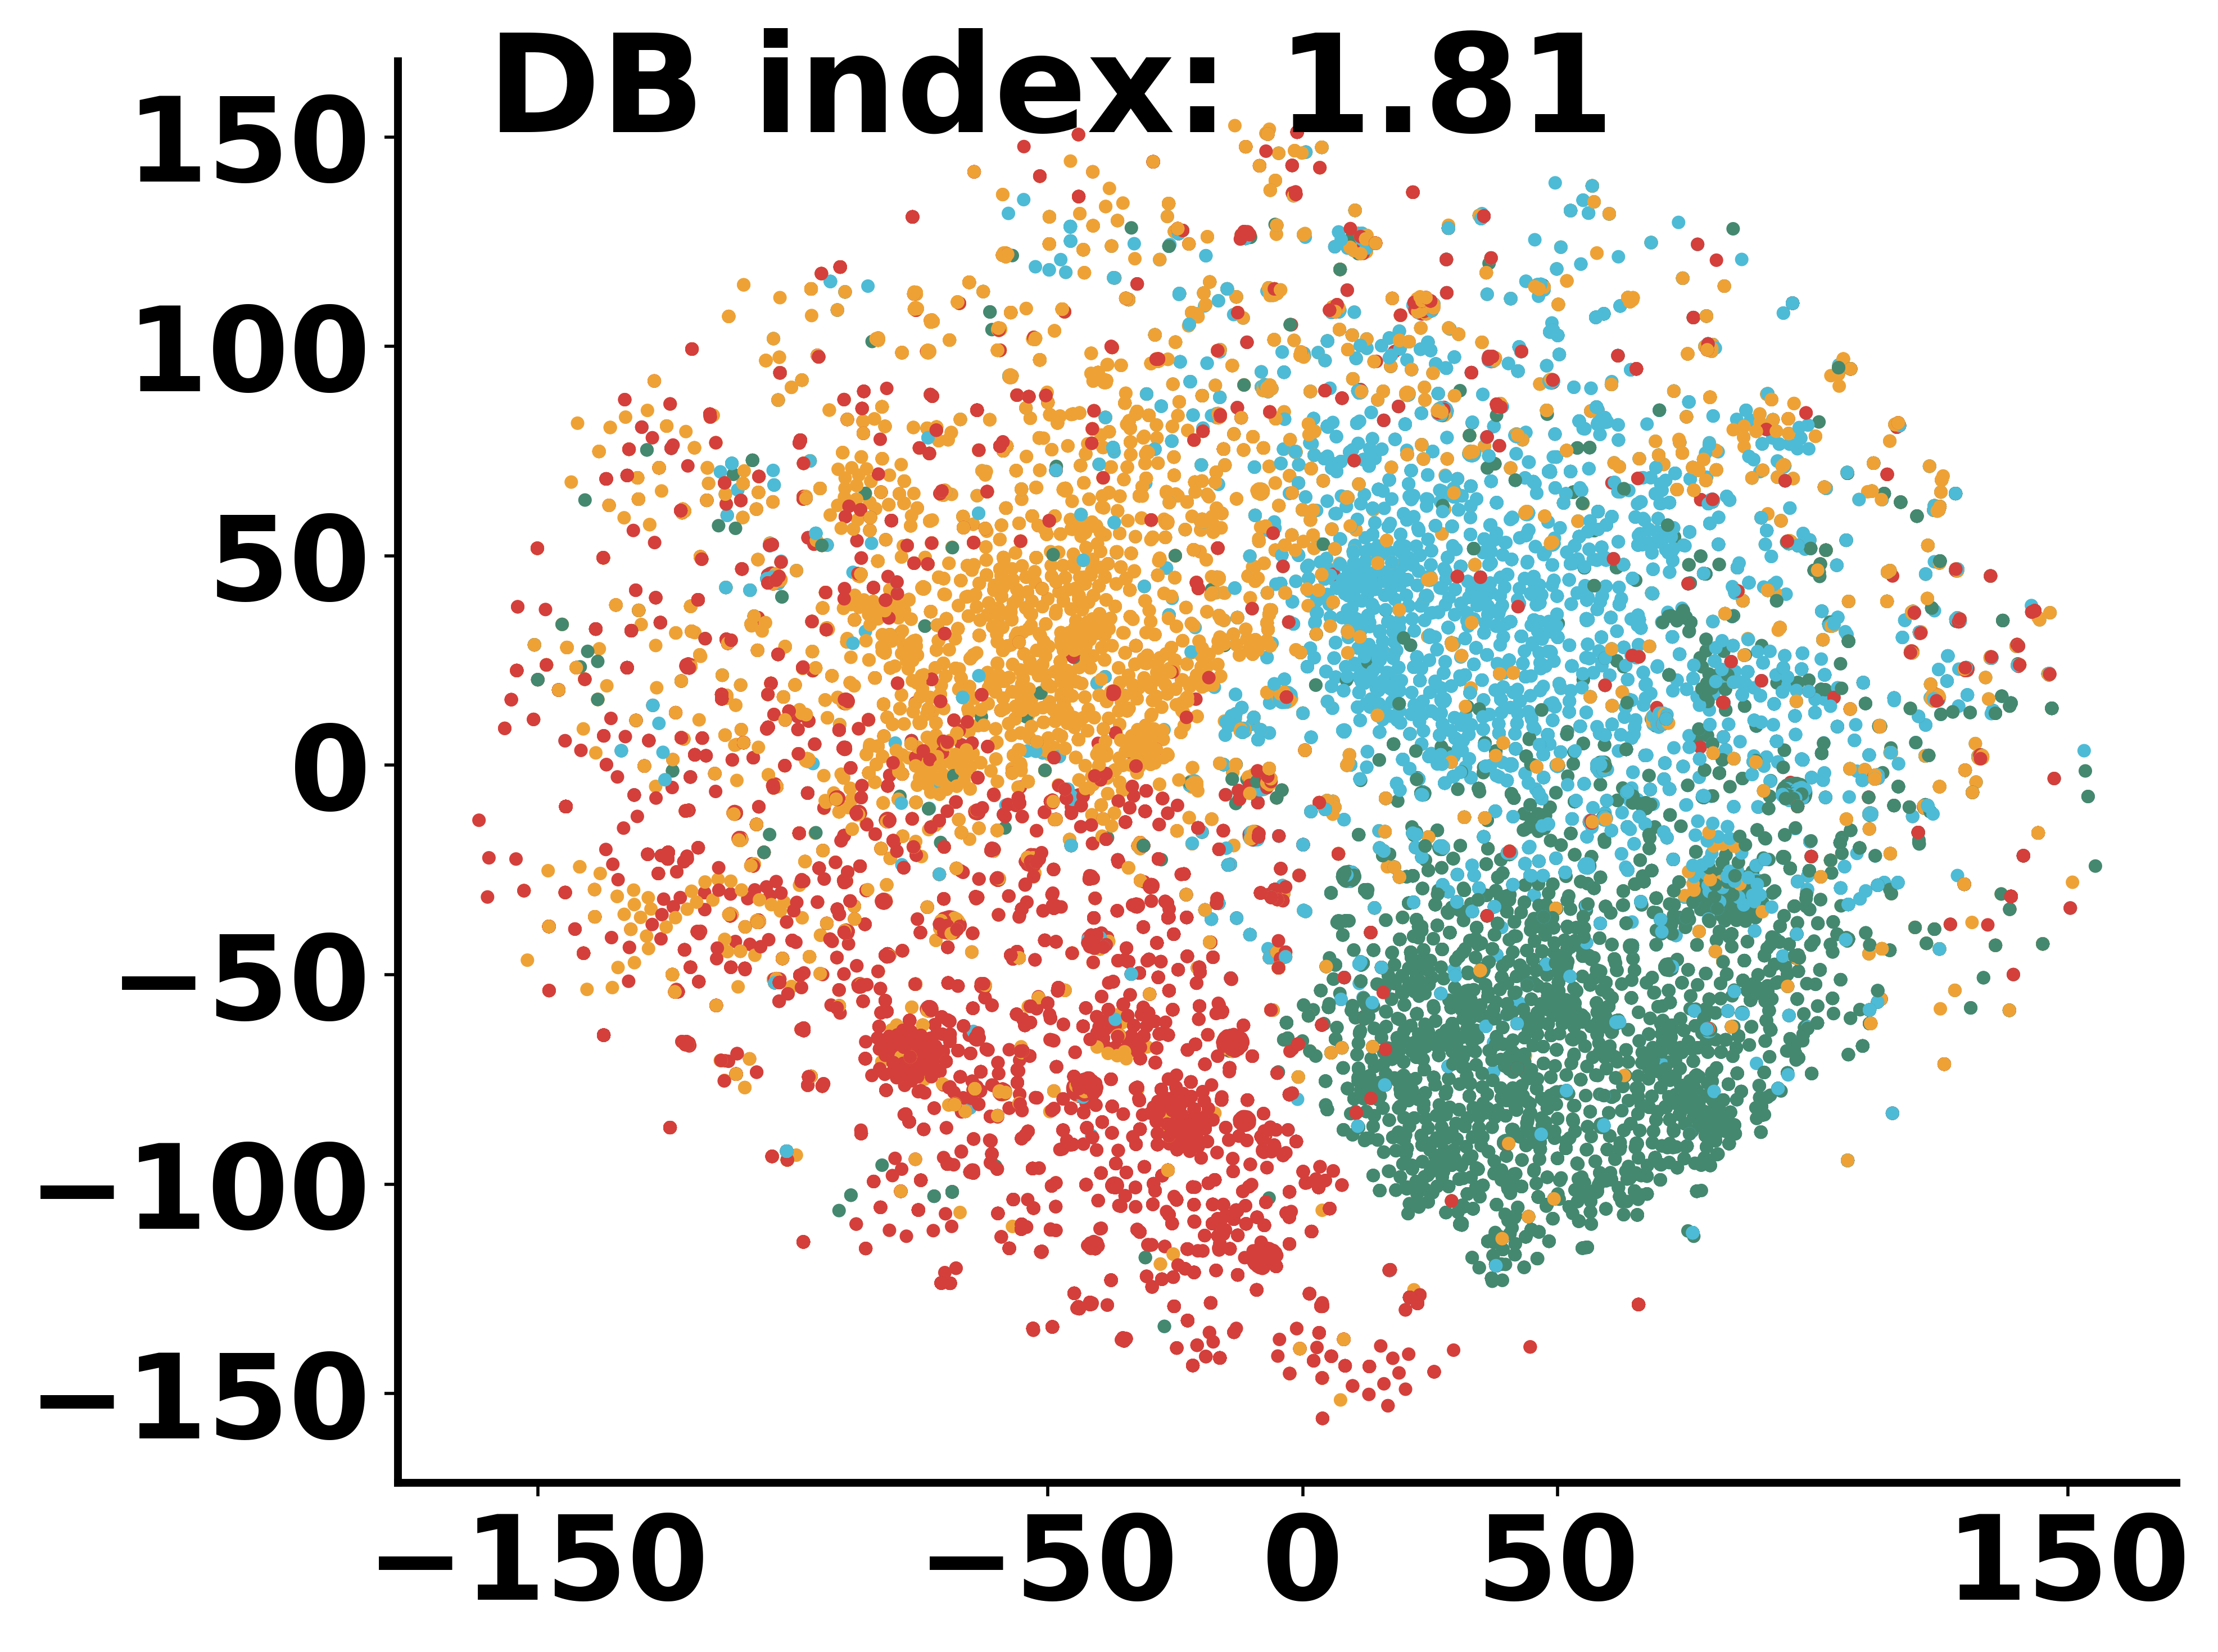

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# 自定义颜色（可根据类别指定）
# custom_palette = {
#     0: "#448870",  # 绿
#     1: "#EEA235",  # 黄
#     2: "#4DBBD6",  # 蓝
#     3: "#D43F3B",  # 红
# }


custom_palette = {
    0: "#D43F3B",  # 红
    1: "#EEA235",  # 黄
    2: "#4DBBD6",  # 蓝
    3: "#448870",  # 绿
}


# 开始绘图
plt.figure(figsize=(8, 6), dpi=500)
sns.scatterplot(
    x=tsne_result[:, 0],
    y=tsne_result[:, 1],
    hue=classification_labels,
    palette=custom_palette,
    s=12,
    edgecolor=None,
    linewidth=0
)

# 添加 DB index 到图中（无边框）
plt.text(0.05, 0.95,
         f"DB index: {dbi_tsne:.2f}",
         transform=plt.gca().transAxes,
         fontsize=35,
         fontweight='bold')


# 去掉图例
plt.legend([], [], frameon=False)

# 坐标轴设置
#plt.xlabel("t-SNE 1", fontsize=20, weight='bold')
#plt.ylabel("t-SNE 2", fontsize=20, weight='bold')
#plt.xticks(fontsize=30, weight='bold')
plt.yticks(fontsize=30, weight='bold')
plt.xticks([-150, -50, 0, 50, 150], fontsize=30, weight='bold')
# 去掉右边框和上边框
sns.despine(top=True, right=True)

# 加粗坐标轴线
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)

plt.tight_layout()
plt.show()

Embeddings shape: (26909, 768)


/tmp/ipykernel_1461/4136015543.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("RdPu")
/tmp/ipykernel_1461/4136015543.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


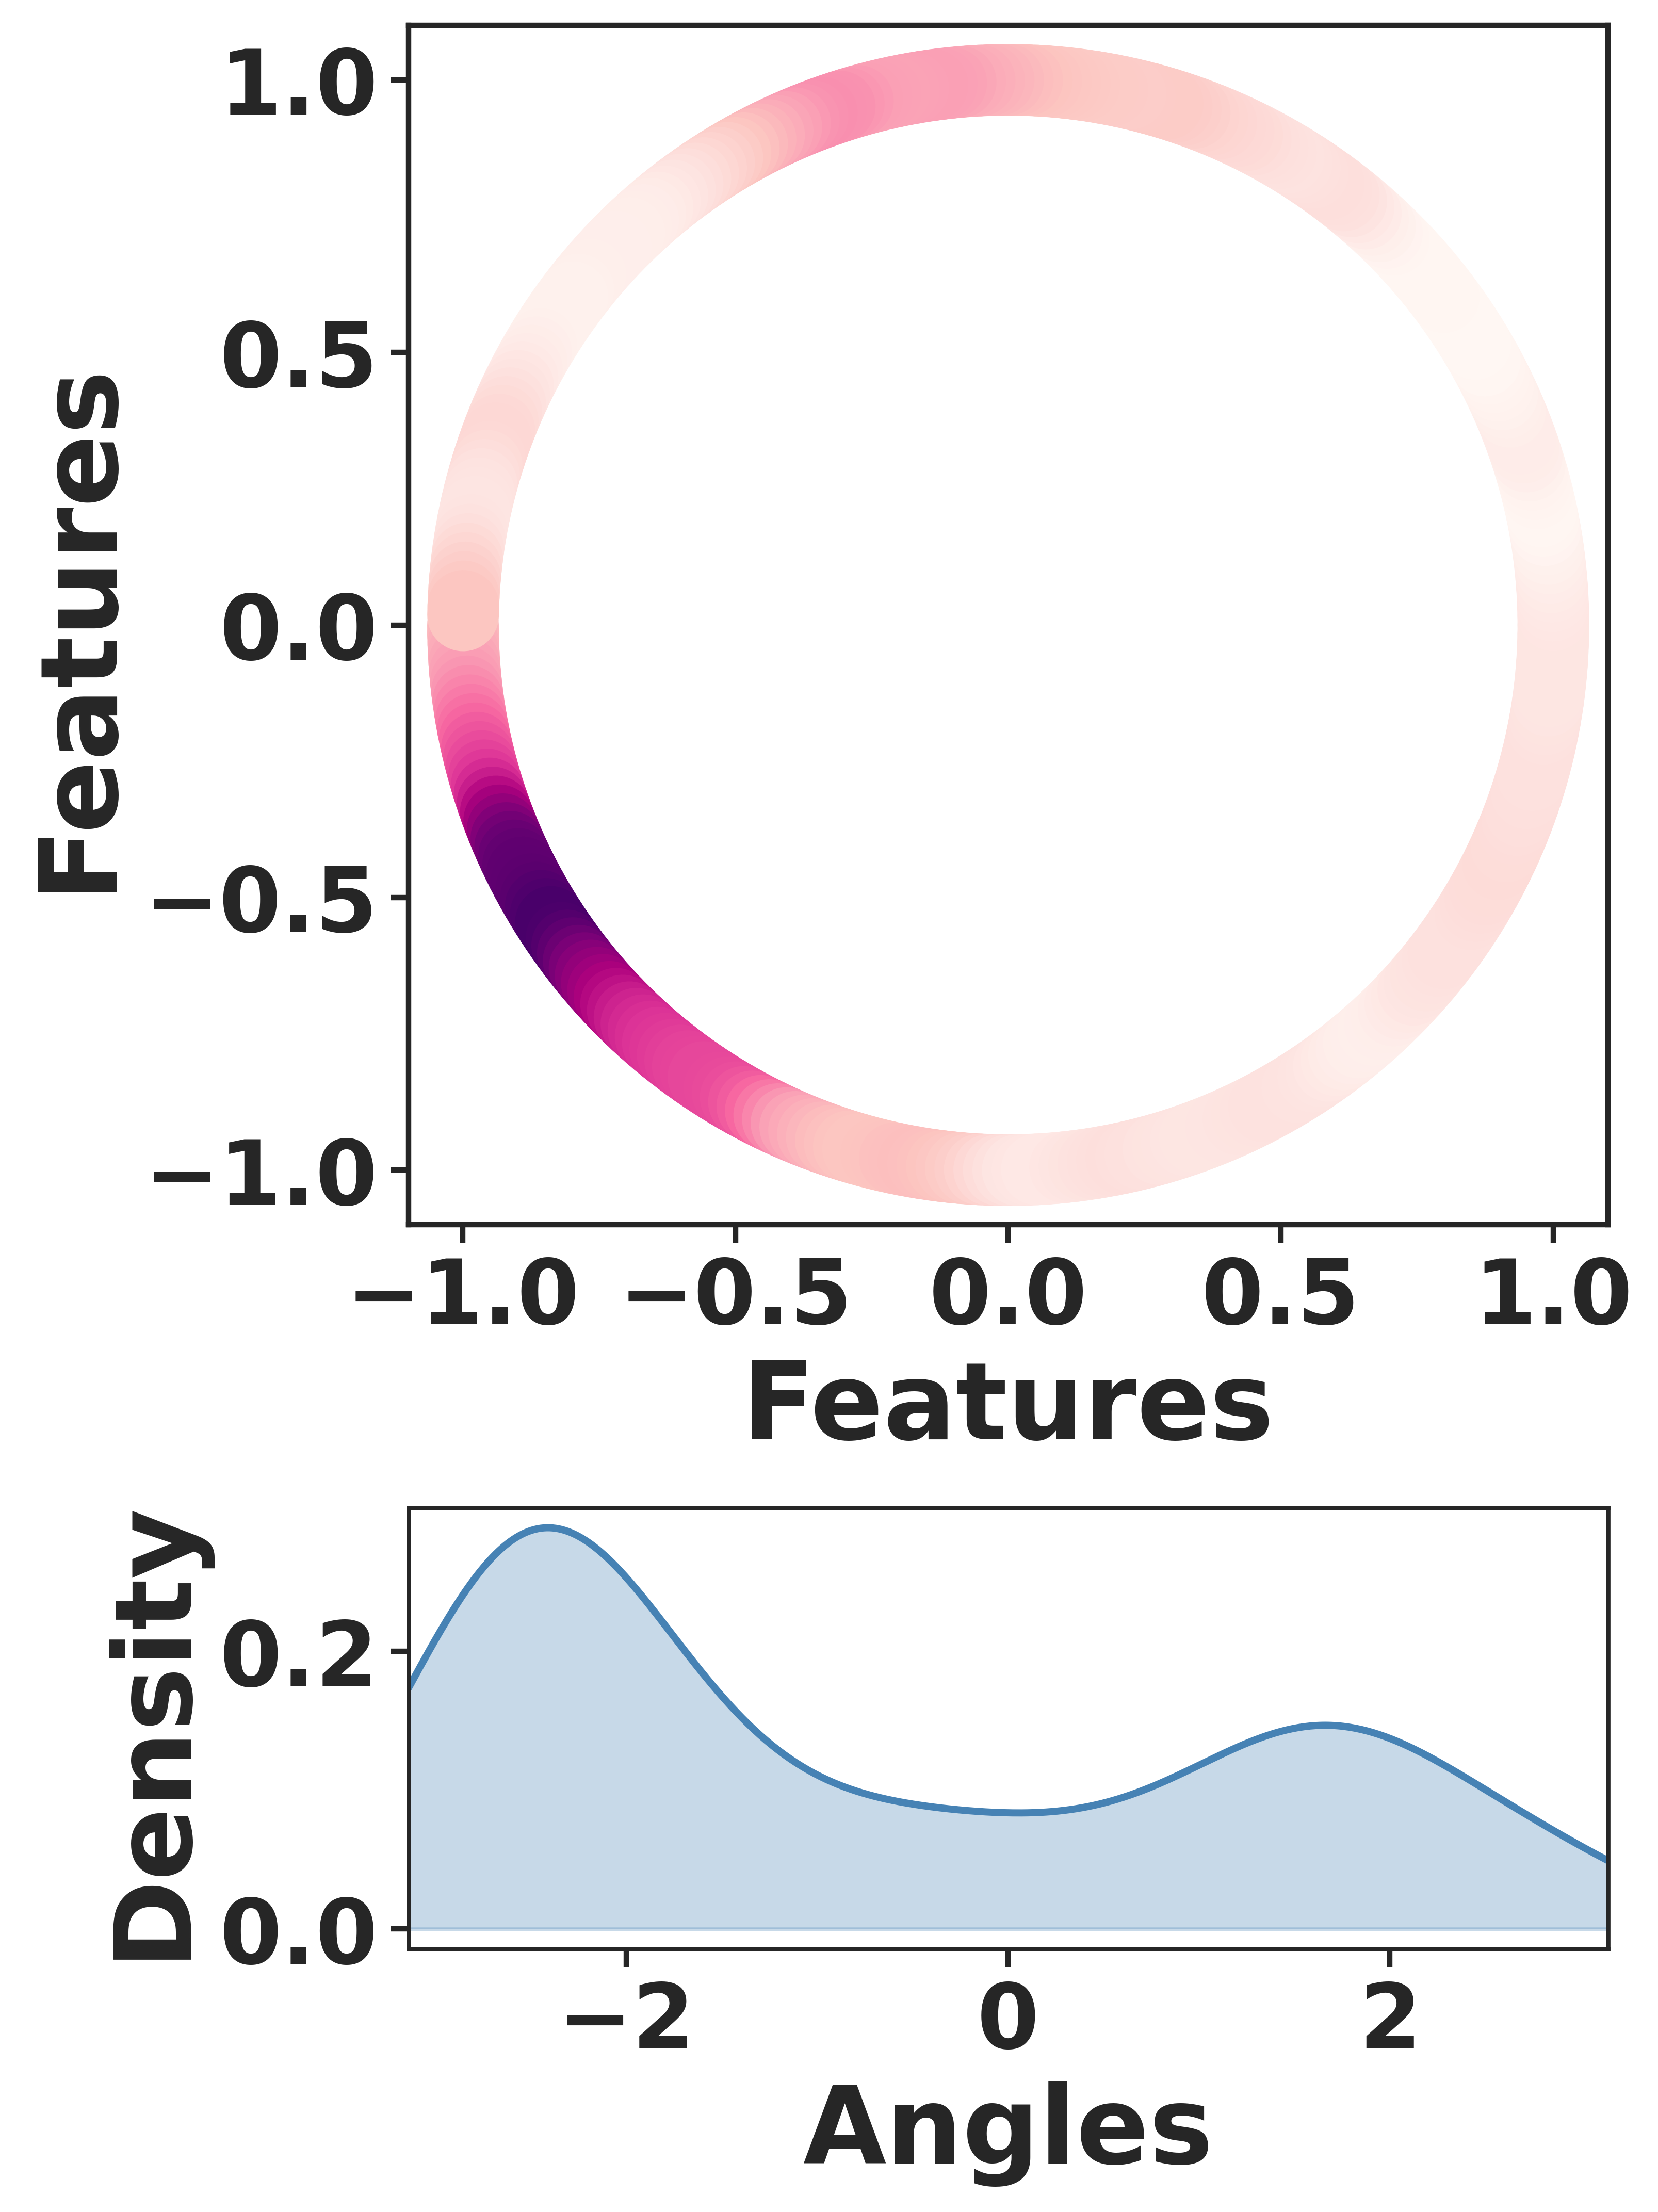

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.random_projection import GaussianRandomProjection
from scipy.stats import gaussian_kde
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import seaborn as sns





# 使用 Seaborn 的 "ticks" 风格，确保刻度线和刻度显示
sns.set_theme(context="notebook", style="ticks")

# ========================
# 1. 加载你的 ChemBERTa 嵌入数据
# ========================
embeddings = np.load("fish_unique_smiles_embeddings.npy")
print("Embeddings shape:", embeddings.shape)

# ========================
# 2. 随机投影 + 单位化
# ========================
# (a) L2 归一化
emb_norm = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
# (b) 随机正交投影到 2D
projector = GaussianRandomProjection(n_components=2, random_state=42)
proj_2d = projector.fit_transform(emb_norm)
# (c) 再次归一化，让所有点都落在单位圆上
proj_2d /= np.linalg.norm(proj_2d, axis=1, keepdims=True)
# (d) 计算每个点的极角 ∈ [-π, π]
angles = np.arctan2(proj_2d[:, 1], proj_2d[:, 0])

# ========================
# 3. 计算 2D KDE 并在圆周上采样
# ========================
kde_2d = gaussian_kde(proj_2d.T, bw_method=0.1)
theta_vals = np.linspace(-np.pi, np.pi, 360, endpoint=False)
ring_x = np.cos(theta_vals)
ring_y = np.sin(theta_vals)
densities = kde_2d(np.vstack([ring_x, ring_y]))
dens_min, dens_max = densities.min(), densities.max()
norm = Normalize(vmin=dens_min, vmax=dens_max)
cmap = cm.get_cmap("RdPu")

# ========================
# 4. 角度分布的 1D KDE
# ========================
kde_1d = gaussian_kde(angles, bw_method=0.3)
x_angle = np.linspace(-np.pi, np.pi, 400)
y_angle = kde_1d(x_angle)

# ========================
# 5. 绘图（dpi=500）
# ========================
fig, (ax_top, ax_bottom) = plt.subplots(
    2, 1,
    figsize=(6, 10),
    gridspec_kw={"height_ratios": [3, 1], "hspace": 0.25},
    dpi=500
)

# ~~~~~~~~~~~~ (A) 上图：彩色环 ~~~~~~~~~~~~
line_width = 20
for i in range(len(theta_vals) - 1):
    x1, y1 = ring_x[i], ring_y[i]
    x2, y2 = ring_x[i+1], ring_y[i+1]
    density_i = densities[i]
    color = cmap(norm(density_i))
    ax_top.plot([x1, x2], [y1, y2], color=color, linewidth=line_width, solid_capstyle='round')

# 叠加虚线圆边框（可选，根据需要开启或关闭）
circle_outline = plt.Circle((0, 0), 1.0, color='black', fill=False, lw=1.5, linestyle='--')
ax_top.add_patch(circle_outline)

# 调整上图坐标与刻度设置
ax_top.set_aspect("equal", "box")
ax_top.set_xlim(-1.1, 1.1)
ax_top.set_ylim(-1.1, 1.1)
ax_top.set_xticks([-1, -0.5, 0, 0.5, 1])
ax_top.set_yticks([-1, -0.5, 0, 0.5, 1])
for spine in ax_top.spines.values():
    spine.set_linewidth(1.5)

# 设置刻度线样式
ax_top.tick_params(which='both', direction='out', length=5, width=1.5, labelsize=25)
# 加粗刻度标签（数字）
for label in ax_top.get_xticklabels() + ax_top.get_yticklabels():
    label.set_fontweight('bold')

# 加粗坐标轴标签
ax_top.set_ylabel("Features", fontsize=30, fontweight='bold')
ax_top.set_xlabel("Features", fontsize=30, fontweight='bold')

# ============ (B) 下图设置 ============
ax_bottom.plot(x_angle, y_angle, color="steelblue", lw=2)
ax_bottom.fill_between(x_angle, y_angle, alpha=0.3, color="steelblue")
ax_bottom.set_xlim(-np.pi, np.pi)
ax_bottom.tick_params(which='both', direction='out', length=5, width=1.5, labelsize=25)
# 加粗刻度标签
for label in ax_bottom.get_xticklabels() + ax_bottom.get_yticklabels():
    label.set_fontweight('bold')

# 加粗坐标轴标签
ax_bottom.set_xlabel("Angles", fontsize=30, fontweight='bold')
ax_bottom.set_ylabel("Density", fontsize=30, fontweight='bold')

plt.tight_layout()
plt.show()